In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras 
import os
import time
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

2023-01-25 19:44:17.630873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 19:44:18.001917: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-25 19:44:18.001935: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-25 19:44:19.110590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [28]:
class ReboilerBinaryClassifier:
    FEATURES_NUM = 8
    OUTPUT_NUM = 2

    def __init__(self, filepath):
        self.filepath = filepath

    def load_data(self):
        data = pd.read_csv(self.filepath)
        return self.process(data)

    def process(self, pandas_df):
        #TODO: Replace this method by Pipeline (from Tensorflow)
        # fill missing values
        for col in pandas_df:
            if pandas_df[col].isnull().any(): # if column has at least one NaN value
                pandas_df[col].fillna(value=pandas_df[col].mean(), inplace=True) # replace NaN with average
            
            # min-max scaling (normalization)
            if pd.to_numeric(pandas_df[col], errors='coerce').notnull().all(): # if columns is composed only by numeric values        
                pandas_df[col] = (pandas_df[col]-pandas_df[col].min())/(pandas_df[col].max()-pandas_df[col].min())

        # hard code to convert 'Fecha' column to datetime ex: 2006-10-24 23:38:00
        pandas_df['Fecha'] =  pd.to_datetime(pandas_df['Fecha'], format='%Y-%m-%d %H:%M:%S')

        # resampling with same timestamp (2h) just to avoid vacancies 
        #TODO before training RNN
        # pandas_df.resample('2H')

        return pandas_df         
                
    def split_data(self, data, val_size=0.2, test_size=0.2):
        X = data.iloc[:, 1:-1] # all rows, all columns except first and last
        y = data.iloc[:, -1] # all rows, last column (label)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=42)
        return X_train, y_train, X_val, y_val, X_test, y_test

    ########################## NEURAL NETWORK MODEL ##########################

    def create_model(self, print_summary=True):    

        model = keras.models.Sequential([
            keras.layers.Dense(32, input_shape=(ReboilerBinaryClassifier.FEATURES_NUM,), activation='sigmoid'),
            # keras.layers.Dense(ReboilerBinaryClassifier.OUTPUT_NUM-1, activation="sigmoid")
            keras.layers.Dense(ReboilerBinaryClassifier.OUTPUT_NUM, activation="softmax")
        ])

        model.compile(
            loss='sparse_categorical_crossentropy', # with softmax (e.g. 0, 1, 2, 3, 4...)
            # loss="binary_crossentropy", # with sigmoid (e.g. 0 or 1)
            optimizer="adam",
            metrics=["accuracy"]
        )
        if print_summary:
            model.summary()

        return model
 
    def train_model(self, model, X_train, y_train, X_val, y_val, X_test, y_test, epochs, *, name=None):
        run_logdir = self.get_run_logdir(name)
        tensorboard_cb = keras.callbacks.TensorBoard(run_logdir) # create event files within run_logdir
        history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=[tensorboard_cb])


    def evaluate_model(self, model, X_test, y_test, save_confusion_matrix=False):
        y_prob = model.predict(X_test) # probabilities
        y_pred = y_prob.argmax(axis=-1) # predictions
        # accuracy = model.evaluate(X_test, y_test)[1] # [loss, accuracy]
        accuracy = accuracy_score(y_test, y_pred)
        print('Accuracy on test set: {}'.format(accuracy))
        disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues', colorbar=False)
        plt.suptitle('Confusion Matrix - {}'.format(model))
        plt.grid(False)   
        if save_confusion_matrix:
            plt.savefig("confusion-matrix.png", dpi=300)
        plt.show()

    ########################## AUXILIARY METHODS ##########################

    @staticmethod
    def get_run_logdir(name=None):    
        root_logdir = os.path.join(os.curdir, "logs")
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") if name is None else name
        return os.path.join(root_logdir, run_id)


In [29]:
r = ReboilerBinaryClassifier('Reboiler_Raw Data_With Timestamps.csv')

In [30]:
r_pandas = r.load_data()

In [31]:
r_pandas.head()

,Fecha,VAL356CI8017-Conductividad,VAL356M003-Carga Motor,VAL356M014-Carga Motor,VAL356M015-Carga Motor,VAL356PI8026-Ind.Presión,VAL356PIC8025-Ind.Presión,VAL356TI8015-Ind.Temperatura,VAL356TIC8014-Ind.Temperatura,Estado
0,2006-10-24 23:38:00,3.075000e-33,0.644380,0.528332,0.460377,0.126248,0.142997,0.513363,0.634987,0.0
1,2006-10-25 01:38:00,4.725000e-33,0.651964,0.531276,0.457091,0.121644,0.140059,0.516451,0.635452,0.0
2,2006-10-25 03:38:00,6.475000e-33,0.652386,0.572375,0.450640,0.123683,0.137120,0.512564,0.636063,0.0
3,2006-10-25 05:38:00,6.800000e-33,0.621948,0.597508,0.437274,0.122217,0.140059,0.503801,0.636798,0.0
4,2006-10-25 07:38:00,5.500000e-33,0.607817,0.541996,0.421190,0.121823,0.138100,0.512467,0.636687,0.0


In [45]:
r_pandas.shape

(42206, 10)

<AxesSubplot:xlabel='Fecha', ylabel='Estado'>

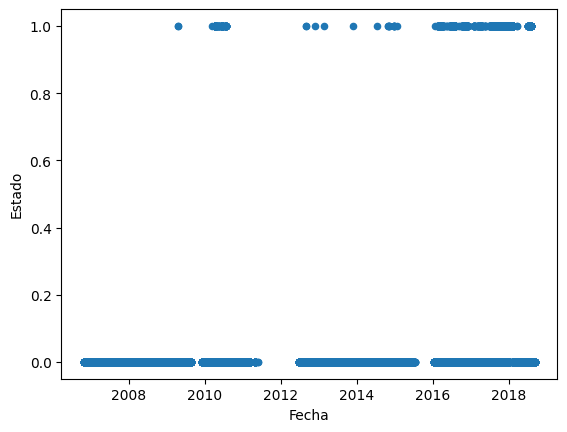

In [44]:
r_pandas.plot.scatter(x='Fecha', y='Estado')

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = r.split_data(r_pandas)

In [7]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (27011, 8)
y_train (27011,)
X_val (6753, 8)
y_val (6753,)
X_test (8442, 8)
y_test (8442,)


In [8]:
model = r.create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 354
Trainable params: 354
Non-trainable params: 0
_________________________________________________________________


2023-01-24 22:13:18.233009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 22:13:18.233401: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-24 22:13:18.233462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-24 22:13:18.233523: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-24 22:13:18.233606: W tensorflow/c

In [9]:
r.train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, name=None)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
798/845 [===========================>..] - ETA: 0s - loss: 0.2569 - accuracy: 0.9285WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fcbd84a3dd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

In [10]:
%reload_ext tensorboard
# %load_ext tensorboard
%tensorboard --logdir=./logs --port=8888

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
264/264 [==============================] - 0s 710us/step
Accuracy on test set: 0.9941956882255389


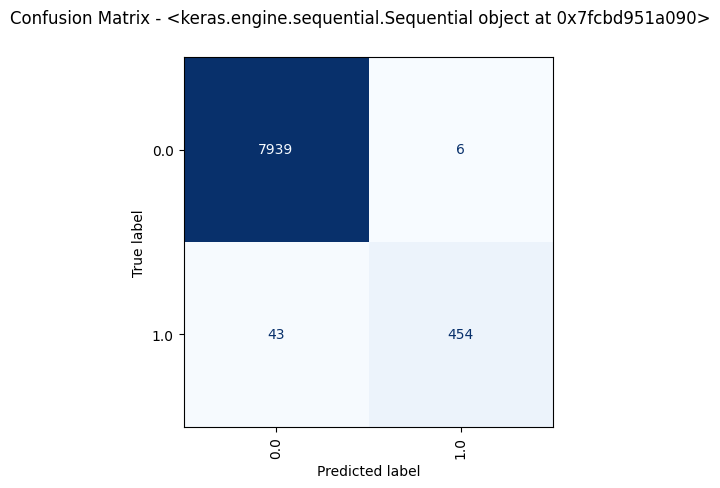

In [11]:
r.evaluate_model(model, X_test, y_test)